In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

## Загрузка и подготовка данных

Загрузим данные по трем регионам разработки:

In [2]:
data0 = pd.read_csv('/datasets/geo_data_0.csv')
data0.name = 'Регион 0'

data1 = pd.read_csv('/datasets/geo_data_1.csv')
data1.name = 'Регион 1'

data2 = pd.read_csv('/datasets/geo_data_2.csv')
data2.name = 'Регион 2'

Проверим данные:
* посмотрим на значения, содержащиеся в датасетах;
* посмотрим, как рапределяются количественные признаки;
* посмотрим, есть ли корреляция между признаками;
* подсчитаем коэффициенты корреляции Спирмена.

Сделаем это в цикле.

*************************
Регион 0
*************************


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99990,NaN,NaN,NaN,NaN
top,Tdehs,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.500419,0.250143,2.502647,92.500000
std,NaN,0.871832,0.504433,3.248248,44.288691
min,NaN,-1.408605,-0.848218,-12.088328,0.000000
25%,NaN,-0.072580,-0.200881,0.287748,56.497507
50%,NaN,0.502360,0.250252,2.515969,91.849972
75%,NaN,1.073581,0.700646,4.715088,128.564089


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Дубликатов:  0


<Figure size 720x720 with 0 Axes>

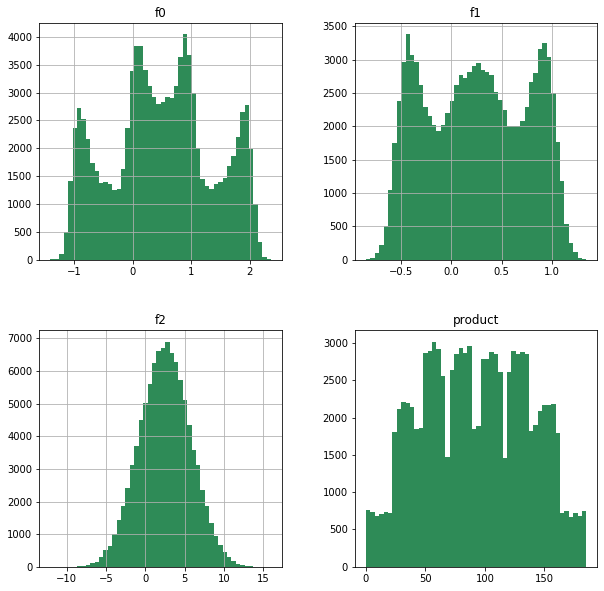

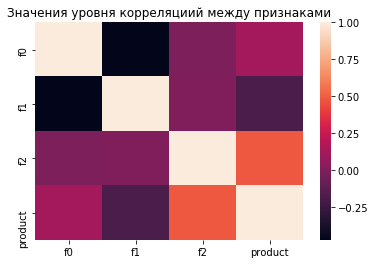

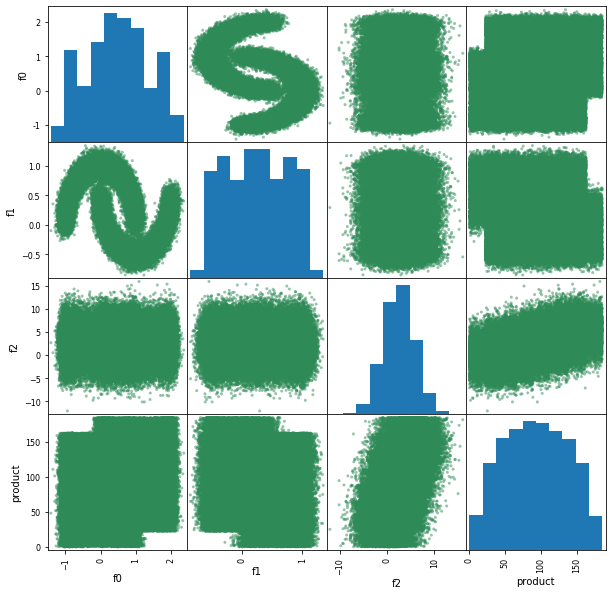

               f0        f1        f2   product
f0       1.000000 -0.471395 -0.002685  0.128417
f1      -0.471395  1.000000  0.001413 -0.181143
f2      -0.002685  0.001413  1.000000  0.486394
product  0.128417 -0.181143  0.486394  1.000000
************************************************

*************************
Регион 1
*************************


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,LHZR0,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,1.141296,-4.796579,2.494541,68.825000
std,NaN,8.965932,5.119872,1.703572,45.944423
min,NaN,-31.609576,-26.358598,-0.018144,0.000000
25%,NaN,-6.298551,-8.267985,1.000021,26.953261
50%,NaN,1.153055,-4.813172,2.011479,57.085625
75%,NaN,8.621015,-1.332816,3.999904,107.813044


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Дубликатов:  0


<Figure size 720x720 with 0 Axes>

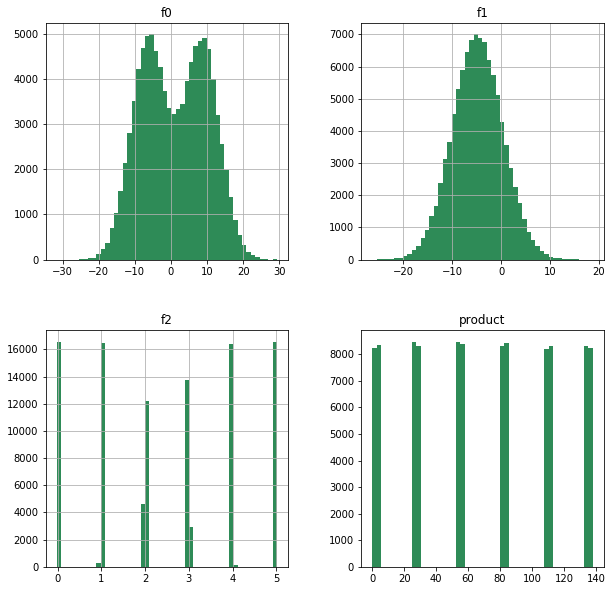

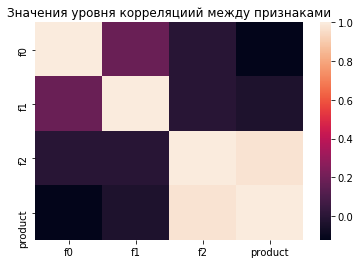

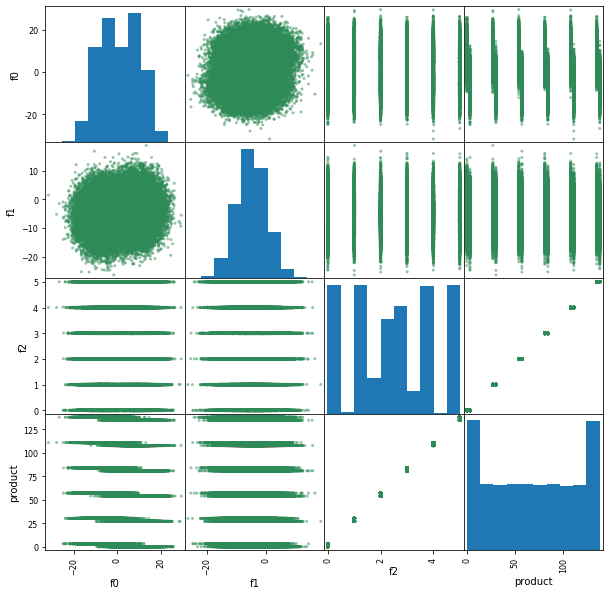

               f0        f1        f2   product
f0       1.000000  0.182248 -0.002000 -0.122869
f1       0.182248  1.000000 -0.003678 -0.033908
f2      -0.002000 -0.003678  1.000000  0.975605
product -0.122869 -0.033908  0.975605  1.000000
************************************************

*************************
Регион 2
*************************


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


,id,f0,f1,f2,product
count,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,99996,NaN,NaN,NaN,NaN
top,VF7Jo,NaN,NaN,NaN,NaN
freq,2,NaN,NaN,NaN,NaN
mean,NaN,0.002023,-0.002081,2.495128,95.000000
std,NaN,1.732045,1.730417,3.473445,44.749921
min,NaN,-8.760004,-7.084020,-11.970335,0.000000
25%,NaN,-1.162288,-1.174820,0.130359,59.450441
50%,NaN,0.009424,-0.009482,2.484236,94.925613
75%,NaN,1.158535,1.163678,4.858794,130.595027


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
Дубликатов:  0


<Figure size 720x720 with 0 Axes>

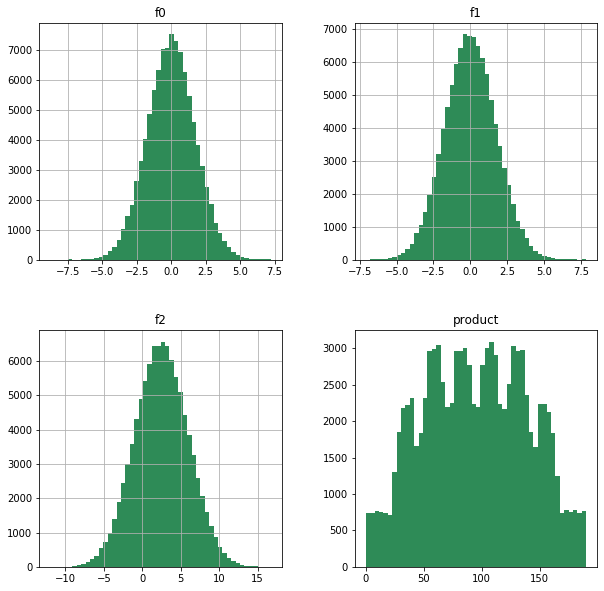

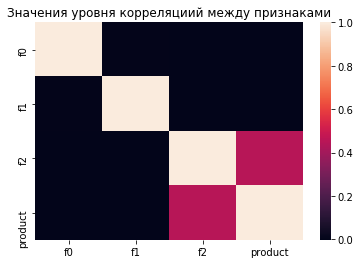

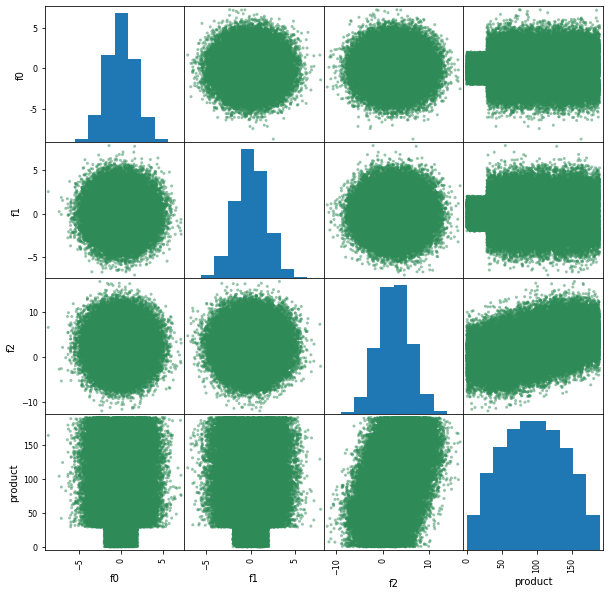

               f0        f1        f2   product
f0       1.000000  0.002493  0.000053 -0.002464
f1       0.002493  1.000000  0.000378 -0.001463
f2       0.000053  0.000378  1.000000  0.448463
product -0.002464 -0.001463  0.448463  1.000000
************************************************



In [3]:
for df in [data0, data1, data2]:
    
    print('*************************')
    print(df.name)
    print('*************************')
    
    display(df.head())
    
    display(df.describe(include='all'))

    print(df.info())

    print('Дубликатов: ', df.duplicated().sum())
    
    
    plt.figure(figsize=(10, 10))
    df.hist(bins=50, figsize=(10,10), color='seagreen', linewidth=2)
    plt.grid()
    plt.show()
    
    s=sns.heatmap(df[['f0', 'f1', 'f2', 'product']].corr(method = 'spearman'))
    s.set_title('Значения уровня корреляциий между признаками')
    plt.show()
    
    pd.plotting.scatter_matrix(df, color='seagreen',figsize=(10, 10))
    plt.show()
    
    print(df.corr(method = 'spearman'))
    
    print('************************************************\n')


### Вывод

* Во всех трех датасетах по 100000 объектов, нигде нет пропусков. 
* Целевым является признак product.
* Признаки распределены по-разному, но хотя бы в одном из датасетов один из признаков (кроме целевого) распределяется нормально.
* Некоторые признаки довольно сильно коррелируют между собой. В каждом регионе наибольшая корреляция между признаком f2 и целевым признаком:
    - Регион 0:
        * корреляция между f2 и product составляет 0.49;
    - Регион 1:
        * корреляция между f2 и product составляет 0.98;
    - Регион 2:
        * корреляция между f2 и product составляет 0.45;


## Обучение и проверка модели

Напишем функцию, которая будет разбивать датасет на тренировочную и валидационную выборки.

In [4]:
model = LinearRegression(n_jobs = -1)
def splitter(data, size):
    data_train, data_valid = train_test_split(data, test_size=size, random_state=299792458)
   
    features_train = data_train.drop(['product', 'id'], axis=1)
    features_valid = data_valid.drop(['product', 'id'], axis=1)
    
    
    target_train = data_train['product']
    target_valid = data_valid['product']

    predictions =  model.fit(features_train, target_train).predict(features_valid)
    rmse = mean_squared_error(target_valid, predictions)**0.5
    
    print('{0}\n********************\n\
средний запас, тыс. баррелей: {1:.2f};\n\
средняя ошибка модели: {2:.2f};'.format(data.name, np.mean(predictions), np.mean(rmse)))
    print('R2:{0:.2f}'.format(r2_score(target_valid, predictions)))
    print('Суммарный запас региона, тыс. баррелей:',round(predictions.sum(), 2))
    print('********************')
    features_valid['product'] = target_valid
    features_valid.loc[:, 'predictions'] = predictions
    features_valid.loc[:, 'rmse'] = rmse
    
    return features_valid.reset_index(drop=True), target_valid.reset_index(drop=True)

Обучим три модели и предскажем целевой признак.

In [5]:
print('!!! БЕЗ СКЕЙЛИНГА !!!')

features_valid_0, target_valid_0 = splitter(data0, 0.25)
features_valid_0.name = 'Регион 0'
features_valid_1, target_valid_1 = splitter(data1, 0.25)
features_valid_1.name = 'Регион 1'
features_valid_2, target_valid_2 = splitter(data2, 0.25)
features_valid_2.name = 'Регион 2'

!!! БЕЗ СКЕЙЛИНГА !!!
Регион 0
********************
средний запас, тыс. баррелей: 92.47;
средняя ошибка модели: 37.68;
R2:0.27
Суммарный запас региона, тыс. баррелей: 2311816.58
********************
Регион 1
********************
средний запас, тыс. баррелей: 68.92;
средняя ошибка модели: 0.89;
R2:1.00
Суммарный запас региона, тыс. баррелей: 1723054.13
********************
Регион 2
********************
средний запас, тыс. баррелей: 94.93;
средняя ошибка модели: 40.13;
R2:0.20
Суммарный запас региона, тыс. баррелей: 2373228.76
********************


### Вывод

* Наименьшее значение ошибки и наибольшее значение коэффициента детерминации в регионе 1. Скорее всего, это связано с высокой корреляцией между признаком f2 и product.
* Регион 1 содержит меньше всего нефти.

## Подготовка к расчёту прибыли

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважин и посчитаем, сколько в среднем необходимо пробурить скважин в каждом регионе. Основные условия:

* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [21]:
BUDGET = 10e9 # бюджет
PRODUCT_UNIT = 450e3 # доход с 1 тыс. баррелей
PRODUCTION = BUDGET/PRODUCT_UNIT
N_WELLS = 200 # число разрабатываемых скважин

print('Минимальное число единиц продукта для окупаемости, тыс. баррелей:',round(PRODUCTION, 2))
print('Средний запас сырья в скважине для безубыточной добычи:', round(PRODUCTION/N_WELLS, 2))

Минимальное число единиц продукта для окупаемости, тыс. баррелей: 22222.22
Средний запас сырья в скважине для безубыточной добычи: 111.11


Посмотрим средние значения для 200 наиболее перспективных скважин:

In [20]:
for df in [features_valid_0, features_valid_1, features_valid_2]:
    print('Средний запас сырья в скважине в регионе "{0}": {1: .2f}'.format(
    df.name, df['predictions'].sort_values(ascending=False).head(200).mean()))

Средний запас сырья в скважине в регионе "Регион 0":  153.32
Средний запас сырья в скважине в регионе "Регион 1":  138.77
Средний запас сырья в скважине в регионе "Регион 2":  148.68


### Вывод

Топ 200 скважин предсказанный нашей моделью, скорее всего, обеспечит безубыточную разработку в любом регионе. Оценим риски.

## Расчёт прибыли и рисков 

Подсчитаем возможную прибыль по 200 наиболее перспективным скважинам каждого региона:

In [8]:
def profit(best_well):
    total_income = best_well.sum()
    total_profit = product_unit*total_income - budget
    return total_profit

In [9]:
for data in [features_valid_0, 
             features_valid_1, 
             features_valid_2]:
    best_well = data['predictions'].sort_values(ascending=False).head(200)
    print('Прибыль для региона "{0}": {1: .2f}'.format(data.name, profit(best_well)))


Прибыль для региона "Регион 0":  3798713933.08
Прибыль для региона "Регион 1":  2489551300.34
Прибыль для региона "Регион 2":  3381428193.29


Напишем функцию для bootstrap, которая будет возвращать среднюю прибыль, 95% доверительный интервал и риск убытков.

In [10]:
def bootstrap(df, iterations):
    count = 0
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(0, iterations):
        product_subsample = df.sample(replace=True, n=500, random_state=state)
        
        income = profit(product_subsample.sort_values(by='predictions',ascending=False)['product'].head(200))
        values.append(income.mean())
        
        if income <= 0:
            count+=1
        
    values = pd.Series(values)
    low = values.quantile(0.05)
    high = values.quantile(0.95)
    
    print('***************{0}*************'.format(df.name))
    print('Средняя прибыль: {0:0.1f}'.format(values.mean()))
    print('95% C.L.:[{0: .2f}; {1: .2f}]'.format(low, high))
    
    pvalue = 1.*count/iterations
    print('Вероятность рисков:{0:0.1%}'.format(pvalue))
    

In [11]:
for data in [features_valid_0, features_valid_1, features_valid_2]:
    bootstrap(data, 1000)

***************Регион 0*************
Средняя прибыль: 400683660.5
95% C.L.:[-41016888.79;  834859361.11]
Вероятность рисков:6.8%
***************Регион 1*************
Средняя прибыль: 462271744.5
95% C.L.:[ 138784282.83;  819483706.87]
Вероятность рисков:1.9%
***************Регион 2*************
Средняя прибыль: 405948575.2
95% C.L.:[-27442019.54;  851189798.13]
Вероятность рисков:6.5%


### Вывод
Наибольшая средняя прибыль ожидается в регионе 1, вероятность убытков в нем также всего в 1.9%. Наша модель, предсказывающая количество запасов нефти в скважинах, на этом регионе показала лучшие результаты. Однако стоит помнить, что в исходных данных признак f2 очень сильно коррелировал с целевым признаком в этом регионе, что, скорее всего и повлияло на итоговый результат.